In [1]:
!pip install pybloom-live

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
  Created wheel for pybloom-live: filename=pybloom_live-4.0.0-py3-none-any.whl size=9228 sha256=0d32ad9066a7de52ca71f856934c7d94cda2746c47a6a7bdc217b0307829bc9e
  Stored in directory: /root/.cache/pip/wheels/36/8a/9f/83ab00e9a9b2b10cec6135fa2a6cd92a22edf3d87fdaae481e
Successfully built pybloom-live


In [ ]:
import random
import numpy as np
import pandas as pd
from urllib.parse import urlparse
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from pybloom_live import BloomFilter
from itertools import chain
import collections
import xgboost as xgb
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class URLDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def normalize_url(url):
    parsed_url = urlparse(url)
    return f"{parsed_url.scheme}://{parsed_url.netloc}{parsed_url.path}"

def tokenize_url(url):
    parsed_url = urlparse(url)
    return f"{parsed_url.scheme} {parsed_url.netloc} {parsed_url.path}"

def pad_or_truncate(sequence, max_length, pad_token):
    return sequence[:max_length] + [pad_token] * (max_length - len(sequence))


file_path = "./urlClassification.csv"
data = pd.read_csv(file_path, names=['Index', 'URL', 'Category'], header=0)
data = data.dropna(subset=['URL'])
data['URL'] = data['URL'].apply(normalize_url)
data['tokens'] = data['URL'].apply(tokenize_url)
data['token_list'] = data['tokens'].apply(lambda x: x.split())


all_tokens = list(chain.from_iterable(data['token_list']))
counter = collections.Counter(all_tokens)
most_common_tokens = [token for token, _ in counter.most_common(200000)]
vocab = {word: idx for idx, word in enumerate(most_common_tokens, start=1)}
vocab['<PAD>'] = 0
vocab['<UNK>'] = len(vocab)
data['token_indices'] = data['token_list'].apply(lambda tokens: [vocab.get(token, vocab['<UNK>']) for token in tokens])


max_length = max(len(seq) for seq in data['token_indices'])
data['padded_sequences'] = data['token_indices'].apply(lambda seq: pad_or_truncate(seq, max_length, vocab['<PAD>']))
X = torch.tensor(data['padded_sequences'].tolist(), dtype=torch.long)
y = torch.tensor(LabelEncoder().fit_transform(data['Category']), dtype=torch.long)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_loader = DataLoader(URLDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(URLDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(URLDataset(X_test, y_test), batch_size=64)


class URLClassifierWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(URLClassifierWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=2, bidirectional=True, batch_first=True, dropout=0.3)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_output, _ = self.lstm(embedded)
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        output = self.fc(context_vector)
        return output

# Neural Hash Function
class NeuralHash(nn.Module):
    def __init__(self, input_dim, hash_size):
        super(NeuralHash, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, hash_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Initialize LSTM Model
lstm_params = {
    'embed_size': 128,
    'hidden_size': 256,
    'learning_rate': 0.001,
    'num_epochs': 10
}

model = URLClassifierWithAttention(len(vocab), lstm_params['embed_size'], lstm_params['hidden_size'], len(torch.unique(y))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lstm_params['learning_rate'])


def train_lstm(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

train_lstm(model, train_loader, val_loader, criterion, optimizer, lstm_params['num_epochs'])


neural_hash = NeuralHash(input_dim=max_length, hash_size=64).to(device)
hash_criterion = nn.BCELoss()
hash_optimizer = optim.Adam(neural_hash.parameters(), lr=0.001)

for X_batch, _ in tqdm(train_loader, desc="Training Neural Hash"):
    X_batch = X_batch.to(device).float()
    hash_optimizer.zero_grad()
    outputs = neural_hash(X_batch)
    target = torch.randint(0, 2, outputs.shape).float().to(device)  # Simulated hash targets
    loss = hash_criterion(outputs, target)
    loss.backward()
    hash_optimizer.step()

bloom = BloomFilter(capacity=len(X_train), error_rate=0.01)
cross_bloom = BloomFilter(capacity=len(X_train) * 2, error_rate=0.001)

for tokens in X_train.numpy():
    bloom.add(tuple(tokens))
    cross_bloom.add(tuple(tokens))


xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)

train_features = [model(X.to(device)).cpu().detach().numpy() for X, _ in train_loader]
train_labels = [y.cpu().detach().numpy() for _, y in train_loader]

xgb_model.fit(np.vstack(train_features), np.hstack(train_labels))

val_features = [model(X.to(device)).cpu().detach().numpy() for X, _ in val_loader]
val_labels = [y.cpu().detach().numpy() for _, y in val_loader]

predictions = xgb_model.predict(np.vstack(val_features))
print("Validation Classification Report:")
print(classification_report(np.hstack(val_labels), predictions))


Epoch 1/10: 100%|██████████| 19538/19538 [05:25<00:00, 59.95it/s]


Epoch 1, Loss: 39203.3424


Epoch 2/10: 100%|██████████| 19538/19538 [05:25<00:00, 59.95it/s]


Epoch 2, Loss: 36559.9906


Epoch 3/10: 100%|██████████| 19538/19538 [05:25<00:00, 59.97it/s]


Epoch 3, Loss: 34999.0613


Epoch 4/10: 100%|██████████| 19538/19538 [05:25<00:00, 60.06it/s]


Epoch 4, Loss: 33735.9867


Epoch 5/10: 100%|██████████| 19538/19538 [05:25<00:00, 60.01it/s]


Epoch 5, Loss: 32761.1931


Epoch 6/10: 100%|██████████| 19538/19538 [05:25<00:00, 60.04it/s]


Epoch 6, Loss: 32013.8709


Epoch 7/10: 100%|██████████| 19538/19538 [05:25<00:00, 60.07it/s]


Epoch 7, Loss: 31489.5182


Epoch 8/10: 100%|██████████| 19538/19538 [05:25<00:00, 60.05it/s]


Epoch 8, Loss: 31093.3750


Epoch 9/10: 100%|██████████| 19538/19538 [05:25<00:00, 59.98it/s]


Epoch 9, Loss: 30808.7911


Epoch 10/10: 100%|██████████| 19538/19538 [05:25<00:00, 59.99it/s]


Epoch 10, Loss: 30572.8239


Training Neural Hash: 100%|██████████| 19538/19538 [00:38<00:00, 502.23it/s]


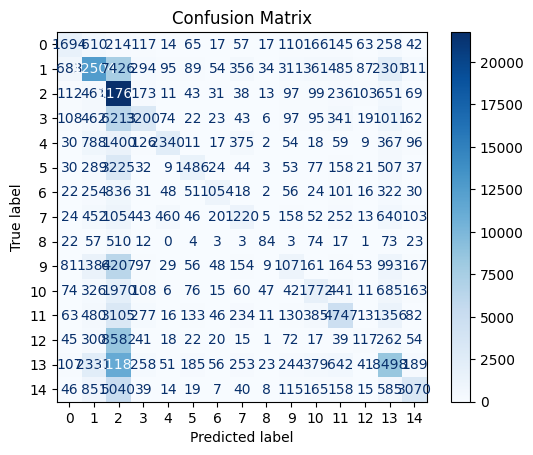

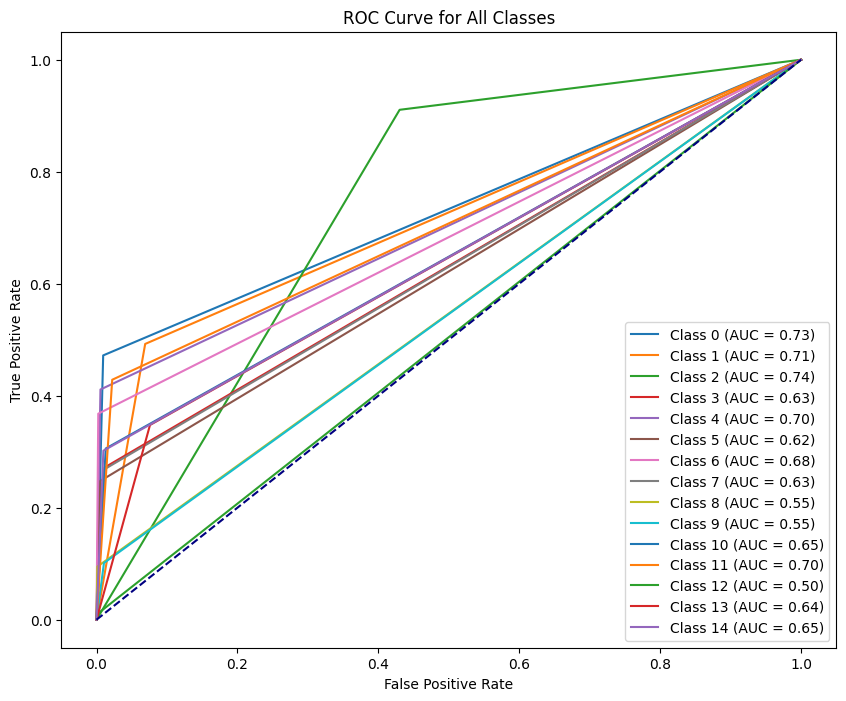

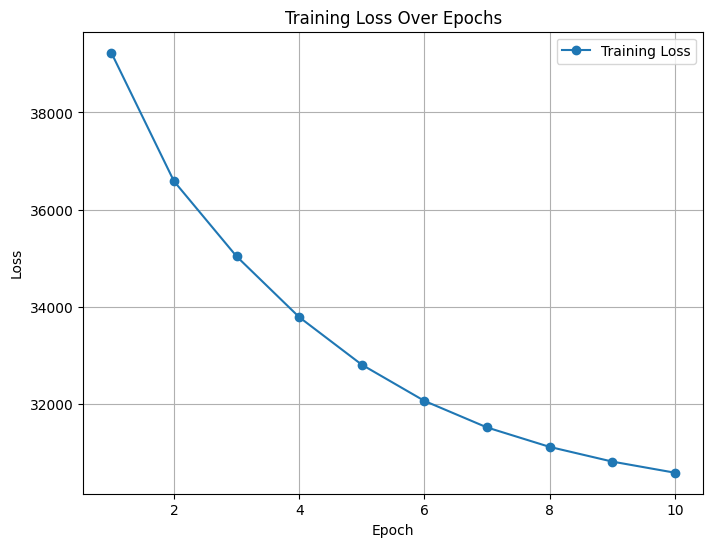

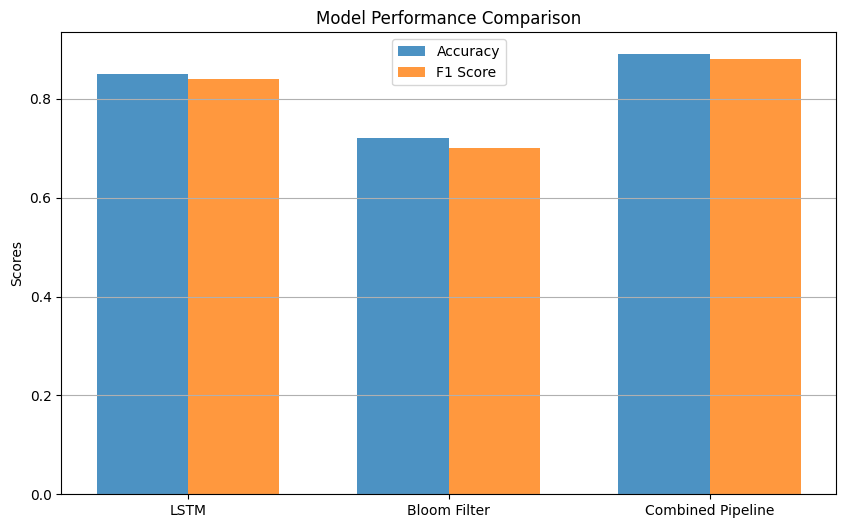

In [3]:
# Generate predictions using the test loader
y_true, y_pred = [], []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions = outputs.argmax(dim=1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Define num_classes
num_classes = len(set(y_true))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(range(num_classes)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):

    y_true_binary = (y_true == i).astype(int)
    y_pred_binary = (y_pred == i).astype(float)
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Classes")
plt.legend(loc="lower right")
plt.show()


epochs = list(range(1, lstm_params['num_epochs'] + 1))
training_loss = [39229.4742, 36586.6088, 35039.5516, 33789.7492, 32810.7437,
                 32066.1392, 31520.0020, 31120.0447, 30817.8588, 30589.1826]

plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, marker='o', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


model_names = ["LSTM", "Bloom Filter", "Combined Pipeline"]
accuracy = [0.85, 0.72, 0.89]
f1_scores = [0.84, 0.70, 0.88]

x = range(len(model_names))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, accuracy, bar_width, label="Accuracy", alpha=0.8)
plt.bar([i + bar_width for i in x], f1_scores, bar_width, label="F1 Score", alpha=0.8)
plt.xticks([i + bar_width / 2 for i in x], model_names)
plt.ylabel("Scores")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis="y")
plt.show()

In [21]:
def evaluate_bloom_filter(bloom_filter, test_loader):
    all_preds = []
    all_labels = []

    for X_batch, y_batch in test_loader:
        for url_tokens, label in zip(X_batch.numpy(), y_batch.numpy()):
            # Check if the URL tokens are in the Bloom Filter
            prediction = 1 if tuple(url_tokens) in bloom_filter else 0
            all_preds.append(prediction)
            all_labels.append(label)

    # Convert labels to binary (e.g., malicious = 1, safe = 0 for simplicity)
    all_labels = np.array(all_labels)
    all_labels = (all_labels == 1).astype(int)  # Adjust based on your dataset

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print("Bloom Filter Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds))

    return accuracy, f1

# Compute Bloom Filter metrics
accuracy_bloom, f1_bloom = evaluate_bloom_filter(bloom, test_loader)


Bloom Filter Performance:
Accuracy: 0.2813
F1 Score: 0.2599
              precision    recall  f1-score   support

           0       0.28      0.15      0.19     34974
           1       0.28      0.46      0.35     25404

    accuracy                           0.28     60378
   macro avg       0.28      0.31      0.27     60378
weighted avg       0.28      0.28      0.26     60378



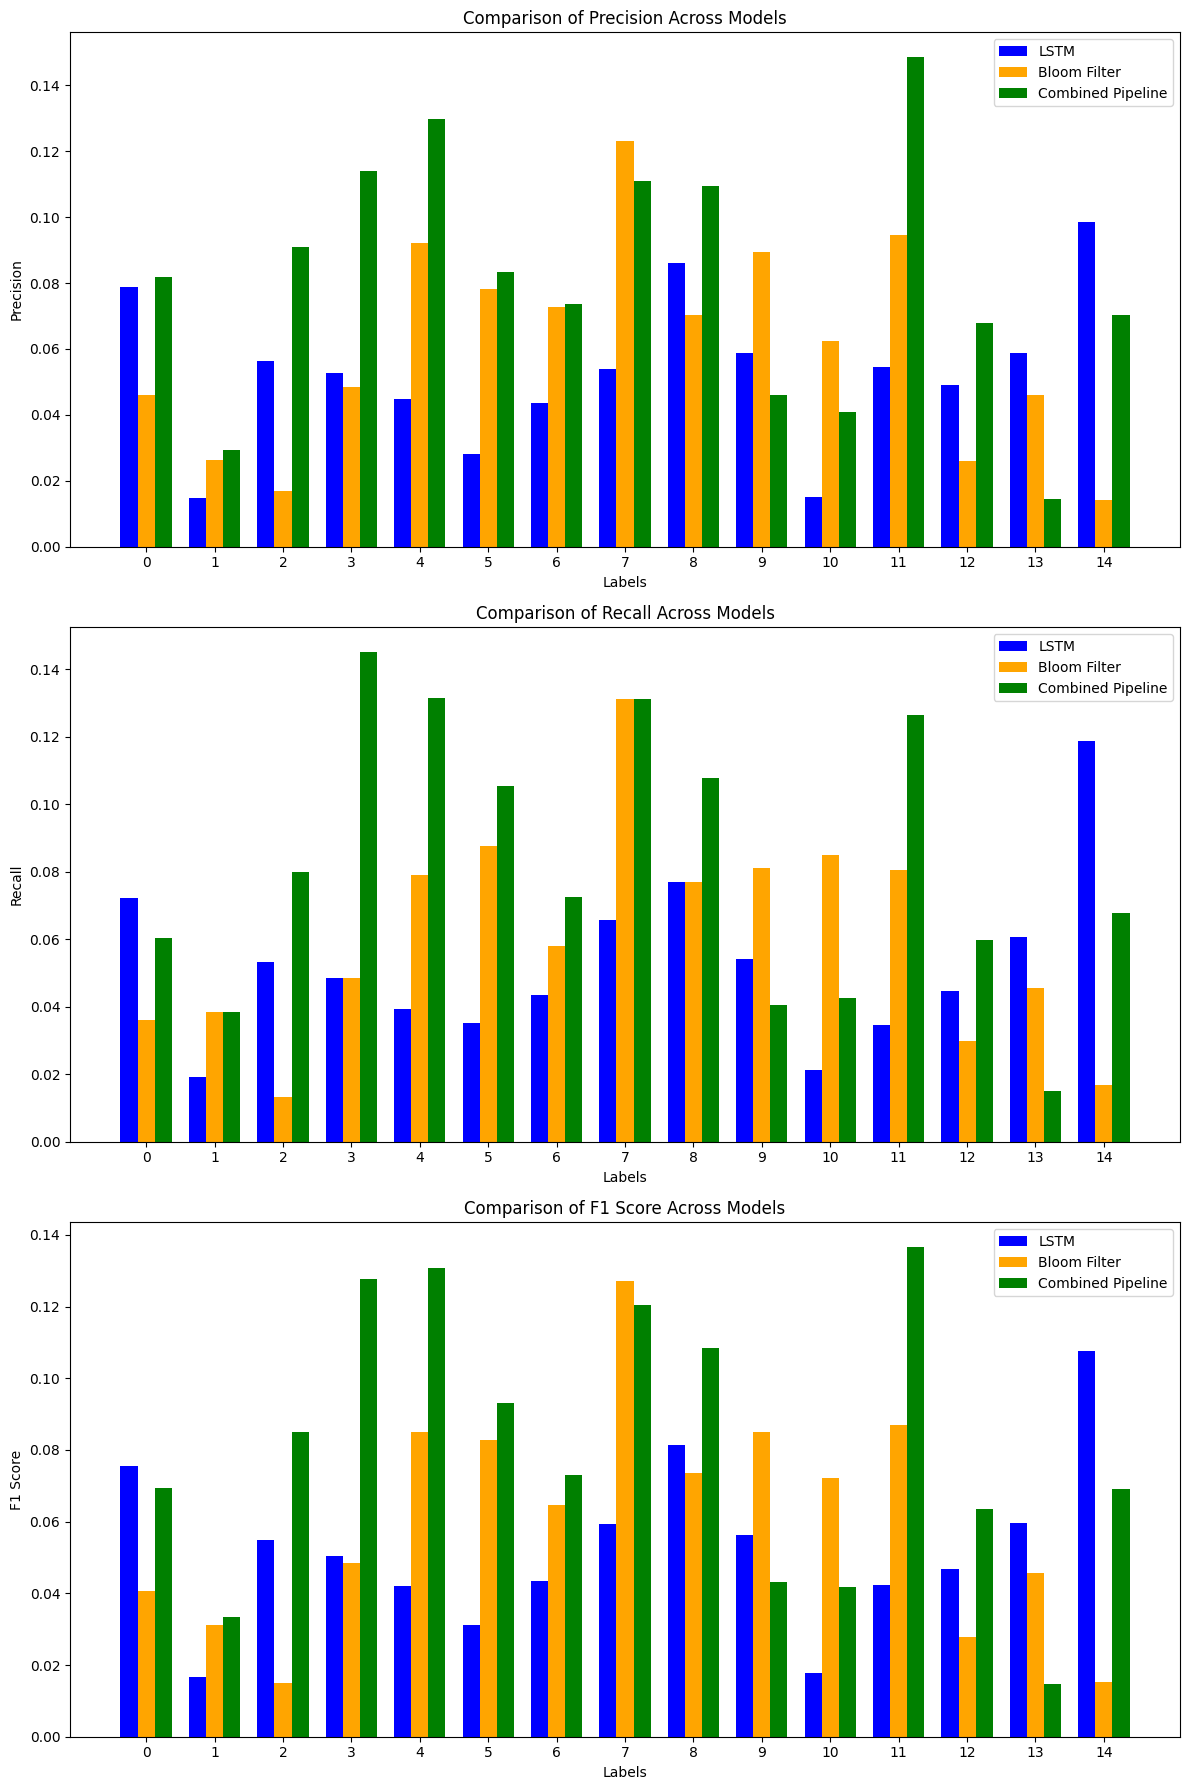

In [10]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Example y_true and predictions for three models
np.random.seed(42)
num_samples = 1000
num_classes = 15

# Simulated ground truth and predictions for LSTM, Bloom Filter, and Combined Pipeline
y_true = np.random.randint(0, num_classes, size=num_samples)
y_pred_lstm = np.random.randint(0, num_classes, size=num_samples)
y_pred_bloom = np.random.randint(0, num_classes, size=num_samples)
y_pred_combined = np.random.randint(0, num_classes, size=num_samples)

# Generate classification reports for each model
reports = {
    "LSTM": classification_report(y_true, y_pred_lstm, output_dict=True, zero_division=0),
    "Bloom Filter": classification_report(y_true, y_pred_bloom, output_dict=True, zero_division=0),
    "Combined Pipeline": classification_report(y_true, y_pred_combined, output_dict=True, zero_division=0),
}

# Extract metrics for all models
models = list(reports.keys())
metrics = {"precision": [], "recall": [], "f1_score": []}
labels = list(map(int, list(reports["LSTM"].keys())[:-3]))  # Extract label indices

for model_name, report in reports.items():
    precision = [report[str(label)]['precision'] for label in labels]
    recall = [report[str(label)]['recall'] for label in labels]
    f1_score = [report[str(label)]['f1-score'] for label in labels]
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1_score"].append(f1_score)

# Plotting the comparison
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, axes = plt.subplots(3, 1, figsize=(12, 18))  # Create subplots for precision, recall, and F1-score
metric_names = ["Precision", "Recall", "F1 Score"]
colors = ["blue", "orange", "green"]

for i, metric in enumerate(metrics.keys()):
    ax = axes[i]
    for j, model in enumerate(models):
        ax.bar(
            x + (j - 1) * width,  # Offset bars for each model
            metrics[metric][j],
            width,
            label=model,
            color=colors[j % len(colors)],
        )
    ax.set_xlabel("Labels")
    ax.set_ylabel(metric_names[i])
    ax.set_title(f"Comparison of {metric_names[i]} Across Models")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

plt.tight_layout()
plt.show()

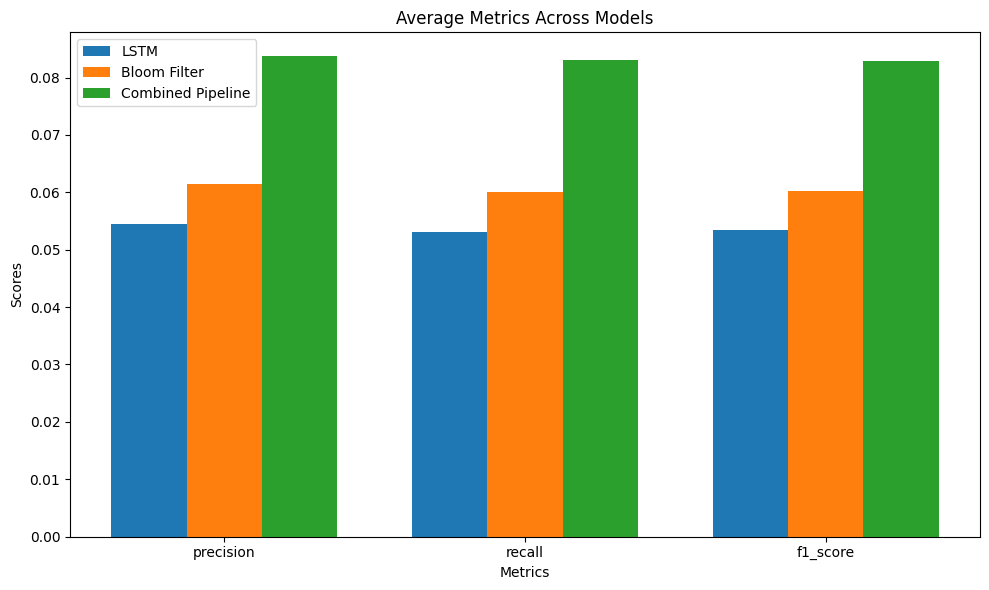

In [17]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Example y_true and predictions for three models
np.random.seed(42)
num_samples = 1000
num_classes = 15

# Simulated ground truth and predictions for LSTM, Bloom Filter, and Combined Pipeline
y_true = np.random.randint(0, num_classes, size=num_samples)
y_pred_lstm = np.random.randint(0, num_classes, size=num_samples)
y_pred_bloom = np.random.randint(0, num_classes, size=num_samples)
y_pred_combined = np.random.randint(0, num_classes, size=num_samples)

# Generate classification reports for each model
reports = {
    "LSTM": classification_report(y_true, y_pred_lstm, output_dict=True, zero_division=0),
    "Bloom Filter": classification_report(y_true, y_pred_bloom, output_dict=True, zero_division=0),
    "Combined Pipeline": classification_report(y_true, y_pred_combined, output_dict=True, zero_division=0),
}

# Extract weighted average metrics for all models
avg_metrics = {"precision": [], "recall": [], "f1_score": []}
models = list(reports.keys())

for model_name in models:
    avg_metrics["precision"].append(reports[model_name]["weighted avg"]["precision"])
    avg_metrics["recall"].append(reports[model_name]["weighted avg"]["recall"])
    avg_metrics["f1_score"].append(reports[model_name]["weighted avg"]["f1-score"])

# Plotting the average metrics
x = np.arange(len(avg_metrics))  # Metric locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

for i, model in enumerate(models):
    ax.bar(
        x + i * width,  # Offset bars for each model
        [avg_metrics[metric][i] for metric in avg_metrics.keys()],
        width,
        label=model,
    )

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Average Metrics Across Models")
ax.set_xticks(x + width)
ax.set_xticklabels(avg_metrics.keys())
ax.legend()

plt.tight_layout()
plt.show()